In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import seaborn as sns
import re
import string

In [23]:
import nltk
import gensim
import gensim.downloader as gensim_api
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from sklearn import feature_extraction, manifold
from pprint import pprint
import tqdm
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read Raw Data

In [15]:
path = 'data/raw_data.txt'
data = pd.read_csv(path, sep=',')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text
date,,,,,,,,,,,,,,,,
2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...
2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...
2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...
2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...
2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...


In [16]:
data.dropna(subset=['text'], inplace=True)

### 1. Preprocessing

Functions to remove of punctuation, make lowercase and strip, remove integer, tokenise words, lemmatise words, remove stopwords


In [17]:
def clean_text(sentence):
    '''
    Description: Main method for cleaning text by removing punctuations, integers, whitespaces and making lowercase
    
    Input:
    * String: The string to be preprocessed.
    
    Return:
    * String: The cleaned string.
    '''
    
    
    def replace_punctuation(sentence):
        '''
        Description: Replaces punctuation in string with space.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string with punctuation replaced with space.
        '''
        return sentence.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))

    def make_lower_and_strip(sentence):
        '''
        Description: Strip string and make lowercase.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string stripped and made lowercase.
        '''
        return re.sub(r'[^\w\s]', '', sentence.lower().strip())

    def remove_integer(sentence):
        '''
        Description: Removes integers in string.

        Input:
        * String: The string to be preprocessed.

        Return:
        * String: The string with integers removed.
        '''
        return re.sub(r'[0-9]+', '', sentence)
    
    try:
        return replace_punctuation(make_lower_and_strip(remove_integer(sentence)))
    except:
        return None

In [18]:
def tokenize(sentence):
    '''
    Description: Tokenizes sentence into list of words.

    Input:
    * String: The string to be tokenized.

    Return:
    * List: The list of words in the sentence.
    '''
    try:
        word_list = sentence.split()
        return word_list
    except:
        return None

In [19]:
def lemmatize(word_list):
    '''
    Description: Lemmatizes list of words.

    Input:
    * List: The list of words to be lemmatized.

    Return:
    * List: The list of words that is lemmatized.
    '''
    try:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        pos_list = ['a', 'r', 'n', 'v']
        for pos in pos_list:
            word_list = [lem.lemmatize(word, pos) for word in word_list]
        return word_list
    except:
        return None

In [20]:
def remove_stopwords(word_list, stopwords=None):
    '''
    Description: Removes stopwords and words with length less than 4.

    Input:
    * List: The list of words to be preprocessed.

    Return:
    * List: The list of words with stopwords and words with length less than 4 removed.
    '''
    try:
        if stopwords is not None:
            return [word for word in word_list if ((word not in stopwords) and len(word) > 3)]
        else:
            return [word for word in word_list if len(word) > 3]
    except:
        return None

### Clean & Tokenize Text

In [21]:
data['cleaned'] = data.text.apply(lambda x: clean_text(x))
data['cleaned_token'] = data.cleaned.apply(lambda x: tokenize(x))
data.head()

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text,cleaned,cleaned_token
date,,,,,,,,,,,,,,,,,,
2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c..."
2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c..."
2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan..."
2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c..."
2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c..."


### Remove Stopwords

In [24]:
stop_words = stopwords.words('english')
data['cleaned_tokenized_nostop'] = data.cleaned_token.apply(lambda x: remove_stopwords(x, stop_words))
data.head()

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text,cleaned,cleaned_token,cleaned_tokenized_nostop
date,,,,,,,,,,,,,,,,,,,
2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan...","[pleased, participate, panel, discussion, inst..."
2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."
2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he..."


### 2. EDA

In [26]:
preprocessed_data = data

In [28]:
def combine_nostop_words(word_list):
  result = " ".join(word_list)
  return result

In [29]:
preprocessed_data['cleaned_nostop'] = preprocessed_data.cleaned_tokenized_nostop.apply(lambda x: combine_nostop_words(x))
preprocessed_data.head()

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF,minutes,speeches,statements,testimony,pressconf,text,cleaned,cleaned_token,cleaned_tokenized_nostop,cleaned_nostop
date,,,,,,,,,,,,,,,,,,,,
2006-01-31,NaN,NaN,15267.026,199.3,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....,A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...",meeting federal open market committee held off...
2006-02-28,NaN,NaN,15267.026,199.4,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...",meeting federal open market committee held off...
2006-03-31,NaN,NaN,15267.026,199.7,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN,I am pleased to participate in the panel disc...,i am pleased to participate in the panel discu...,"[i, am, pleased, to, participate, in, the, pan...","[pleased, participate, panel, discussion, inst...",pleased participate panel discussion institute...
2006-04-30,NaN,NaN,15302.705,200.7,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...",meeting federal open market committee held off...
2006-05-31,NaN,NaN,15302.705,201.3,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody...",A meeting of the Federal Open Market Committe...,a meeting of the federal open market committee...,"[a, meeting, of, the, federal, open, market, c...","[meeting, federal, open, market, committee, he...",meeting federal open market committee held off...


In [56]:
path = 'data/preprocessed.txt'
preprocessed_data.to_csv(path, sep=',', index=True, header=True)

### 1. EDA - Macro data

In [30]:
macro = preprocessed_data.iloc[:, 0:10]
macro

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
date,,,,,,,,,,
2006-01-31,NaN,NaN,15267.026,199.300,4.7,135429.0,179293.0,8371156.0,12.050690,4.285161
2006-02-28,NaN,NaN,15267.026,199.400,4.8,135737.0,177887.0,8371156.0,12.412857,4.491429
2006-03-31,NaN,NaN,15267.026,199.700,4.7,136047.0,178100.0,8371156.0,11.716129,4.589355
2006-04-30,NaN,NaN,15302.705,200.700,4.7,136205.0,178088.0,8420042.0,11.863333,4.790333
2006-05-31,NaN,NaN,15302.705,201.300,4.6,136244.0,177200.0,8420042.0,14.411613,4.940323
...,...,...,...,...,...,...,...,...,...,...
2020-10-31,0.0,0.25,18794.426,260.462,6.9,142545.0,212005.0,27747798.0,29.059677,0.090000
2020-11-30,0.0,0.25,18794.426,260.927,6.7,142809.0,208966.0,27747798.0,24.806000,0.086333
2020-12-31,0.0,0.25,18794.426,261.560,6.7,142503.0,205818.0,27747798.0,22.198710,0.090000


In [31]:
macro.describe()

,DFEDTARL,DFEDTARU,GDPC1,CPIAUCSL,UNRATE,PAYEMS,RRSFS,GFDEBTN,VIXCLS,DFF
count,147.000000,147.000000,182.000000,182.000000,182.000000,182.000000,182.000000,1.820000e+02,182.000000,182.000000
mean,0.416054,0.666054,16843.935352,231.593258,6.307692,139332.175824,182519.857143,1.651441e+07,19.477572,1.225636
std,0.710177,0.710177,1315.678058,17.259565,2.208909,6428.542218,14417.940707,5.186453e+06,9.147815,1.668144
min,0.000000,0.250000,15134.117000,199.300000,3.500000,129698.000000,155179.000000,8.371156e+06,10.010645,0.049000
25%,0.000000,0.250000,15671.383000,217.304250,4.600000,134377.750000,173616.750000,1.231135e+07,13.506855,0.117766
50%,0.000000,0.250000,16531.685000,233.196500,5.600000,138004.000000,179347.000000,1.677138e+07,16.768532,0.196500
75%,0.500000,0.750000,17977.299000,244.180750,8.200000,144085.500000,193909.000000,1.997683e+07,22.382161,1.913629
max,2.250000,2.500000,19253.959000,263.161000,14.800000,152523.000000,220845.000000,2.774780e+07,62.457419,5.258929


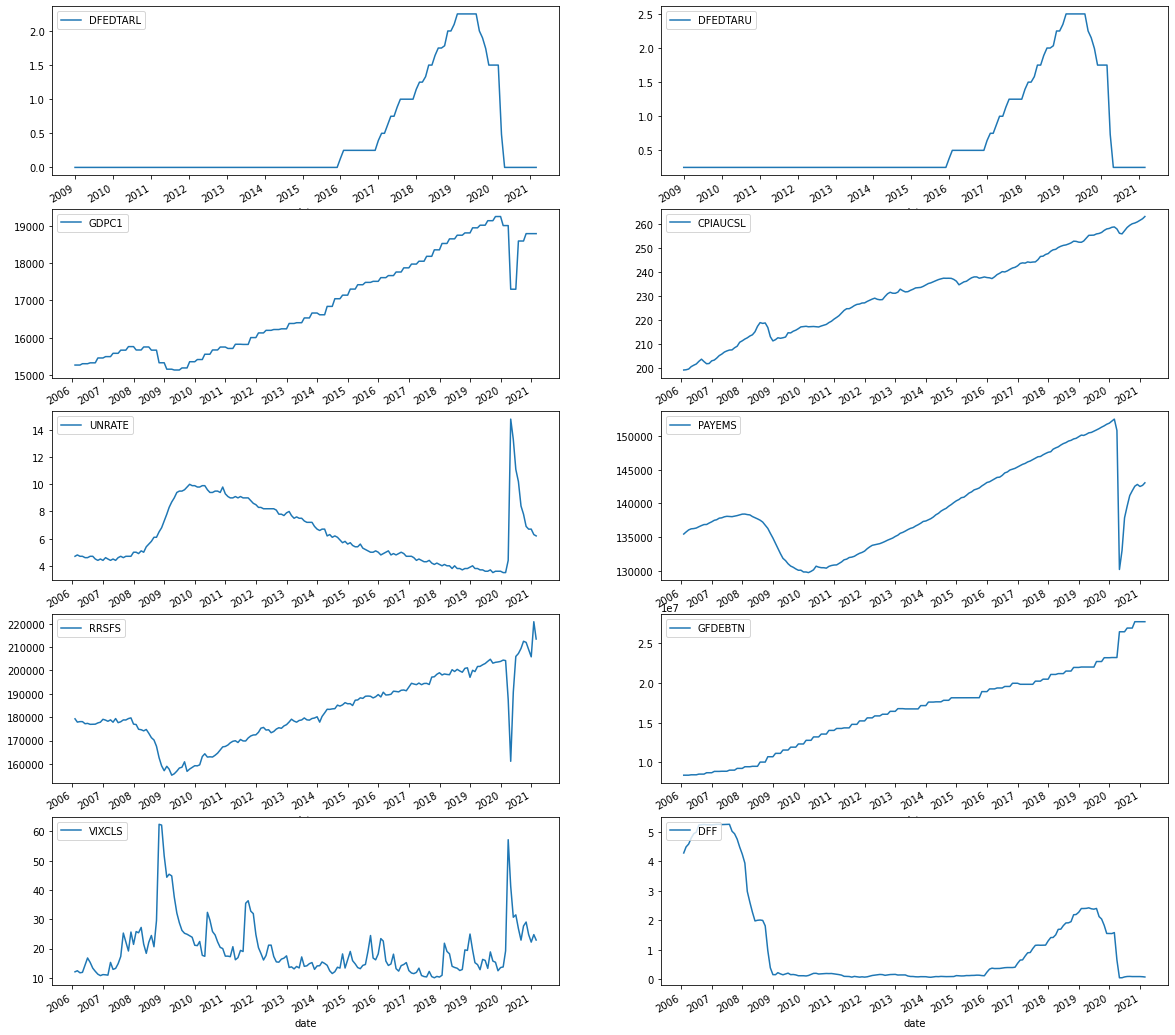

In [32]:
# Plot of macroeonomic data from 2006 to present
fig = plt.figure(figsize=(20,20))

index = 1
for indicator in list(macro.columns):
  df = macro[[indicator]]
  ax = plt.subplot(5,2,index)
  df.plot(ax=ax, x_compat=True)
  ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  ax.legend(loc="upper left")
  index += 1

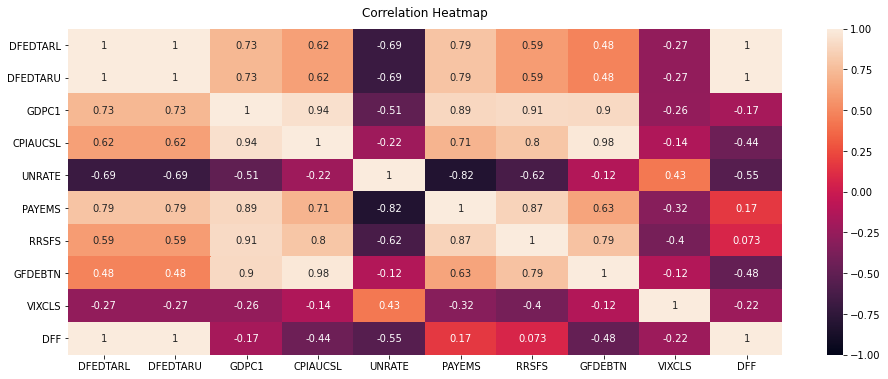

In [33]:
# Correlation heatmap
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(macro.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### 2. EDA - Textual Data

#### Count of posts of each type

In [36]:
textual = preprocessed_data.iloc[:, 10:15]
textual

,minutes,speeches,statements,testimony,pressconf
date,,,,,
2006-01-31,A meeting of the Federal Open Market Committe...,I thank you for the invitation to speak today...,The Federal Open Market Committee decided tod...,Chairman Bernanke presented identical testimo...,CHAIRMAN GREENSPAN. Thank you all very much....
2006-02-28,A meeting of the Federal Open Market Committe...,I appreciate the opportunity to speak to you ...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Welcome, everyone. It ha..."
2006-03-31,NaN,I am pleased to participate in the panel disc...,NaN,"Mr. Chairman and members of the Committee, I ...",NaN
2006-04-30,A meeting of the Federal Open Market Committe...,I would like to thank Operation HOPE and the ...,The Federal Open Market Committee decided tod...,"Chairman Hagel, Senator Dodd, and members of ...","CHAIRMAN BERNANKE. Good morning, everyone. ..."
2006-05-31,A meeting of the Federal Open Market Committe...,I am pleased to be here this afternoon to par...,The Federal Open Market Committee decided tod...,"Chairman Shelby, Senator Sarbanes, and member...","CHAIRMAN BERNANKE. Good afternoon, everybody..."
...,...,...,...,...,...
2020-10-31,"November 4-5, 2020A joint meeting of the Fede...","Two years ago, I had the pleasure of visiting...",The Federal Reserve is committed to using its...,Vice Chair for Supervision Quarles submitted ...,CHAIR POWELL. Good afternoon. At the Federa...
2020-11-30,"December 15-16, 2020\nA joint meeting of the ...",The Federal Reserve is committed to providing...,The Federal Reserve is committed to using its...,Chair Powell submitted identical remarks to t...,CHAIR POWELL. Good afternoon. At the Federa...
2020-12-31,"January 26-27, 2021A joint meeting of the Fed...",Current Economic Situation and Outlook\nIn th...,The Federal Reserve is committed to using its...,NaN,CHAIR POWELL. Good afternoon. At the Federa...


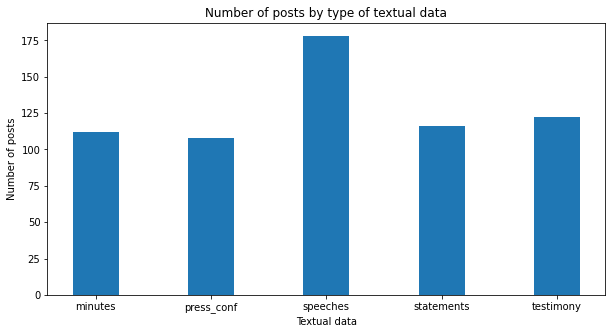

In [37]:
# Plot of number of posts for each type after preprocessing
post_count = {
    'minutes': textual[['minutes']].dropna().shape[0],
    'press_conf': textual[['pressconf']].dropna().shape[0],
    'speeches': textual[['speeches']].dropna().shape[0],
    'statements': textual[['statements']].dropna().shape[0],
    'testimony': textual[['testimony']].dropna().shape[0]
}

fig = plt.figure(figsize = (10, 5))
plt.bar(list(post_count.keys()), list(post_count.values()), width = 0.4)
plt.xlabel("Textual data")
plt.ylabel("Number of posts")
plt.title("Number of posts by type of textual data")
plt.show()

#### Word Cloud / Word Frequency

Functions to plot word cloud and word frequency chart

In [39]:
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

def plot_word_cloud(text):
    wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='Set2', 
                      collocations=False, stopwords = STOPWORDS).generate(text)

    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud) 
    plt.axis("off")

In [40]:
from collections import Counter

def plot_word_frequency(text):
  result = Counter(text.split()).most_common()[0:20] # top 20 most common words
  result_df = pd.DataFrame(columns=['word', 'count'])
  for r in result:
    result_df.loc[len(result_df)] = [r[0], r[1]]

  sns.barplot(x=result_df['count'],y=result_df['word'], palette="rocket")

##### Full time frame: 2006 - 2021

In [44]:
full_text = ""
for text in preprocessed_data.cleaned_nostop:
  full_text += text

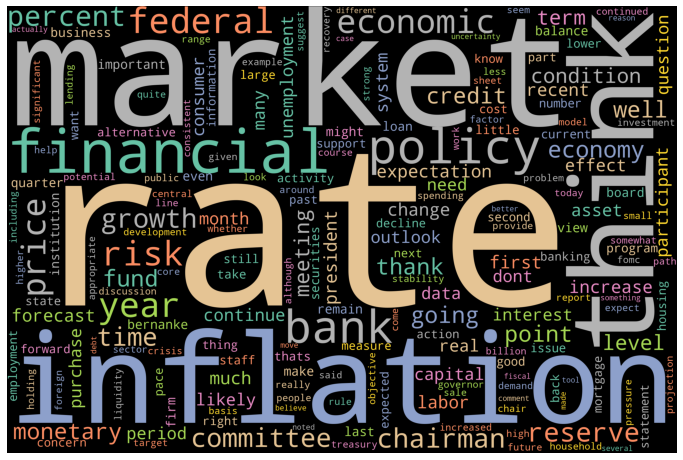

In [45]:
plot_word_cloud(full_text)

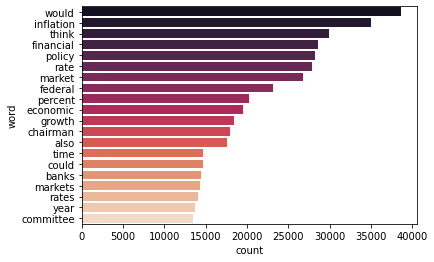

In [46]:
plot_word_frequency(full_text)

Financial Crisis (Dec 2007 - June 2009)

In [47]:
fin_crisis_period = preprocessed_data[(preprocessed_data.index >= pd.to_datetime('2007-12-01')) & (preprocessed_data.index <= pd.to_datetime('2009-06-30'))]

In [48]:
full_text = ""
for text in fin_crisis_period.cleaned_nostop:
  full_text += text

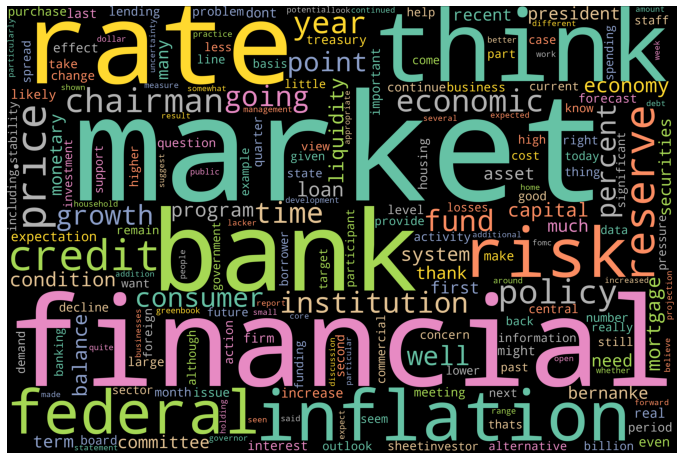

In [49]:
plot_word_cloud(full_text)

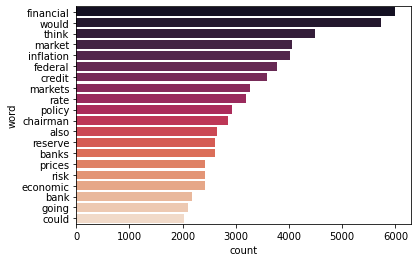

In [50]:
plot_word_frequency(full_text)

##### Covid-19 (Dec 2019 - 2021)

In [51]:
covid_period = preprocessed_data[preprocessed_data.index >= pd.to_datetime('2019-12-31')]

In [52]:
full_text = ""
for text in covid_period.cleaned_nostop:
  full_text += text

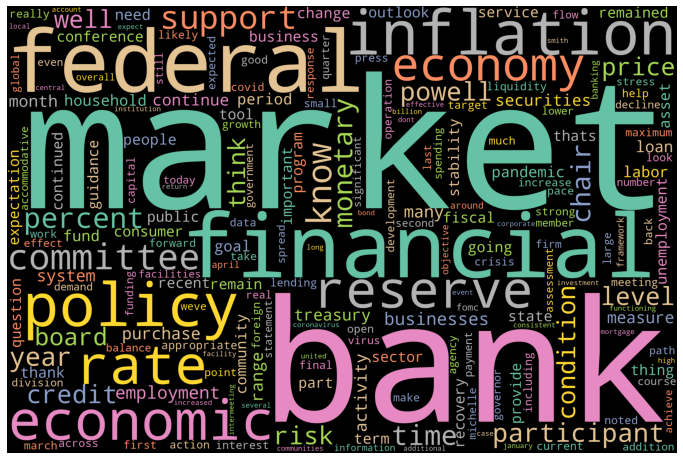

In [53]:
plot_word_cloud(full_text)

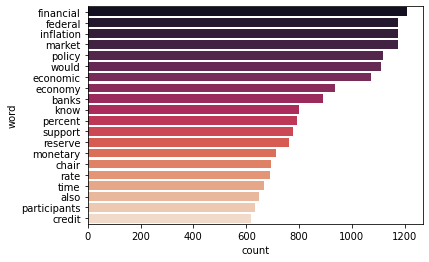

In [54]:
plot_word_frequency(full_text)